In [1]:
import xarray as xr
from xhistogram.xarray import histogram
import gsw
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline

In [3]:
woa = xr.open_mfdataset('../WOA13/*.nc', decode_times=False,
                        combine='by_coords', chunks={'time': 1})

In [4]:
# compute potential temperature (there should be a better way!!!)
depth, _ = xr.broadcast(woa['depth'], woa['t_an'])
lat, _ = xr.broadcast(woa['lat'], woa['t_an'])
depth = depth.transpose(*('time', 'depth', 'lat', 'lon'))
lat = lat.transpose(*('time', 'depth', 'lat', 'lon'))
woa['s_an'].load()
woa['t_an'].load()
depth.load()
lat.load()
woa['tpot'] = xr.zeros_like(woa['t_an'])
woa['tpot'][:] = gsw.pt_from_t(woa['s_an'].values, woa['t_an'].values, 
                               gsw.p_from_z(depth.values, lat.values), 0.)

In [5]:
woa_annual = woa.mean(dim='time')

/home/raphaeldussin/anaconda3/envs/prod/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/raphaeldussin/anaconda3/envs/prod/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/raphaeldussin/anaconda3/envs/prod/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [6]:
sbins = np.arange(31,38, 0.025)
tbins = np.arange(-2, 32, 0.1)

In [7]:
hTS = histogram(woa_annual['s_an'], woa_annual['tpot'], bins=[sbins, tbins])

/home/raphaeldussin/anaconda3/envs/prod/lib/python3.7/site-packages/xarray/core/computation.py:603: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


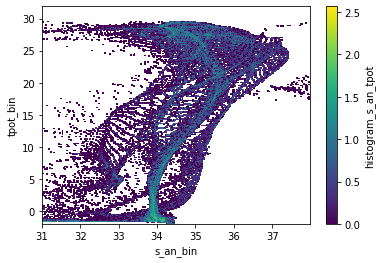

In [8]:
np.log10(hTS.transpose()).plot()

In [9]:
hTS.sel(s_an_bin=slice(34.8, 35.), tpot_bin=slice(1.5,4)).sum()

<xarray.DataArray 'histogram_s_an_tpot' ()>
array(116)

In [10]:
# Create a dz variable
dz = np.diff(woa['depth'])
dz =np.insert(dz, 0, dz[0])
dz = xr.DataArray(dz, coords= {'depth': woa['depth']}, dims='depth')

# weight by volume of grid cell (resolution = 5degree, 1degree=110km)
dVol = dz * (110e3) * (110e3*np.cos(woa['lat']*np.pi/180))

In [11]:
#hTSv = histogram(woa['s_an'].isel(time=slice(0,12)), 
#                 woa['tpot'].isel(time=slice(0,12)), 
#                 bins=[sbins, tbins], weights=dVol,
#                 dim=('lon', 'lat', 'depth'))

In [12]:
hTSv = histogram(woa['s_an'], 
                 woa['tpot'], 
                 bins=[sbins, tbins], weights=dVol,
                 dim=('lon', 'lat', 'depth'))

In [13]:
vol_nadw = hTSv.sel(s_an_bin=slice(34.8, 35.), 
                    tpot_bin=slice(1.5,4)).sum(dim=['s_an_bin', 'tpot_bin'])

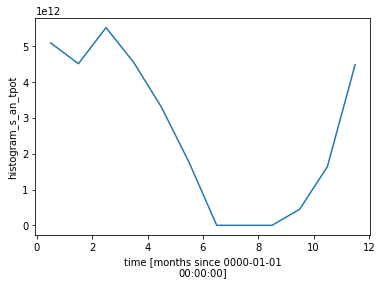

In [14]:
vol_nadw.plot()